# Online Policy Evaluation

##### The contextual bandit problem is very similar to multi-class or multi-label classification (with the reward being whether the right label was chosen or not), but with the big difference that the right label or set of labels is not known for each observation, only whether the label that was chosen by the agent for each observation was correct or not.


##### Data for contextual bandits is not easily available, and it's hard to work with in terms of evaluation, but it is possible to turn any multi-label classification dataset into contextual bandits by revealing only the class for one label per observation. Doing this also has the advantage that we know also the rewards for all other arms when we want to evaluate a policy, but we can choose not to reveal them to the agent to simulate a real scenario.

##### For eg
* Observation 1: [1, 0, 1]  (belongs to A and C)
* Observation 2: [0, 1, 1]  (belongs to B and C)
* Observation 3: [1, 1, 0]  (belongs to A and B)
* For Observation 1, we might reveal only A (or B or C), simulating a scenario where the agent gets feedback only for the chosen action.
##### This transformation allows us to evaluate the agent's performance based on all label information (A, B, and C) even though we simulate the agent seeing only partial feedback.

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import  LogisticUCB,EpsilonGreedy,AdaptiveGreedy,SoftmaxExplorer,BootstrappedTS
from copy import deepcopy
import cloudpickle

In [8]:
train_df=pd.read_csv('train_data.csv')
test_df=pd.read_csv('test_data.csv')
train_labels=pd.read_csv('train labels.csv')

In [10]:
train_df=train_df.drop(['id'],axis=1)
test_df=test_df.drop(['id'],axis=1)
train_labels=train_labels.drop(['id'],axis=1)

In [28]:
labels=train_labels.columns.to_list()

In [11]:
X=train_df.to_numpy()
y=train_labels.to_numpy()

In [20]:
nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)
### Important!!! the default values for beta_prior will be changed in version 0.3

## The base algorithm is embedded in different metaheuristics
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                               beta_prior = beta_prior, random_state = 4444)
logistic_ucb = LogisticUCB(nchoices = nchoices, percentile = 70,
                           beta_prior = beta_prior_ts, random_state = 5555)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                      decay_type='percentile', decay=0.9997,
                                       beta_prior=beta_prior, random_state = 7777)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior=beta_prior, random_state = 5678)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior = beta_prior_ts, random_state = 2222)

models = [epsilon_greedy, logistic_ucb, adaptive_greedy_perc,softmax_explorer,bootstrapped_ts]

In [21]:
rewards_egr,rewards_lucb,rewards_agr, rewards_sft , rewards_bts= [list() for _ in range(len(models))]
lst_rewards = [rewards_egr,rewards_lucb, rewards_agr, rewards_sft,rewards_bts]

batch_size = 50

first_batch = X[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)

lst_a_egr,lst_a_lucb, lst_a_agr, lst_a_sft, lst_a_bts = [action_chosen.copy() for _ in range(len(models))]
lst_actions = [ lst_a_egr,lst_a_lucb, lst_a_agr, lst_a_sft, lst_a_bts]

def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)

    # Choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')

    # Keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())

    # Adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)

    # Now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist])

    return new_actions_hist

for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])

    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model], lst_rewards[model], lst_actions[model], X, y, batch_st, batch_end)

/home/yuvraj/Coding/Contextual Bandit/cb_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yuvraj/Coding/Contextual Bandit/cb_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

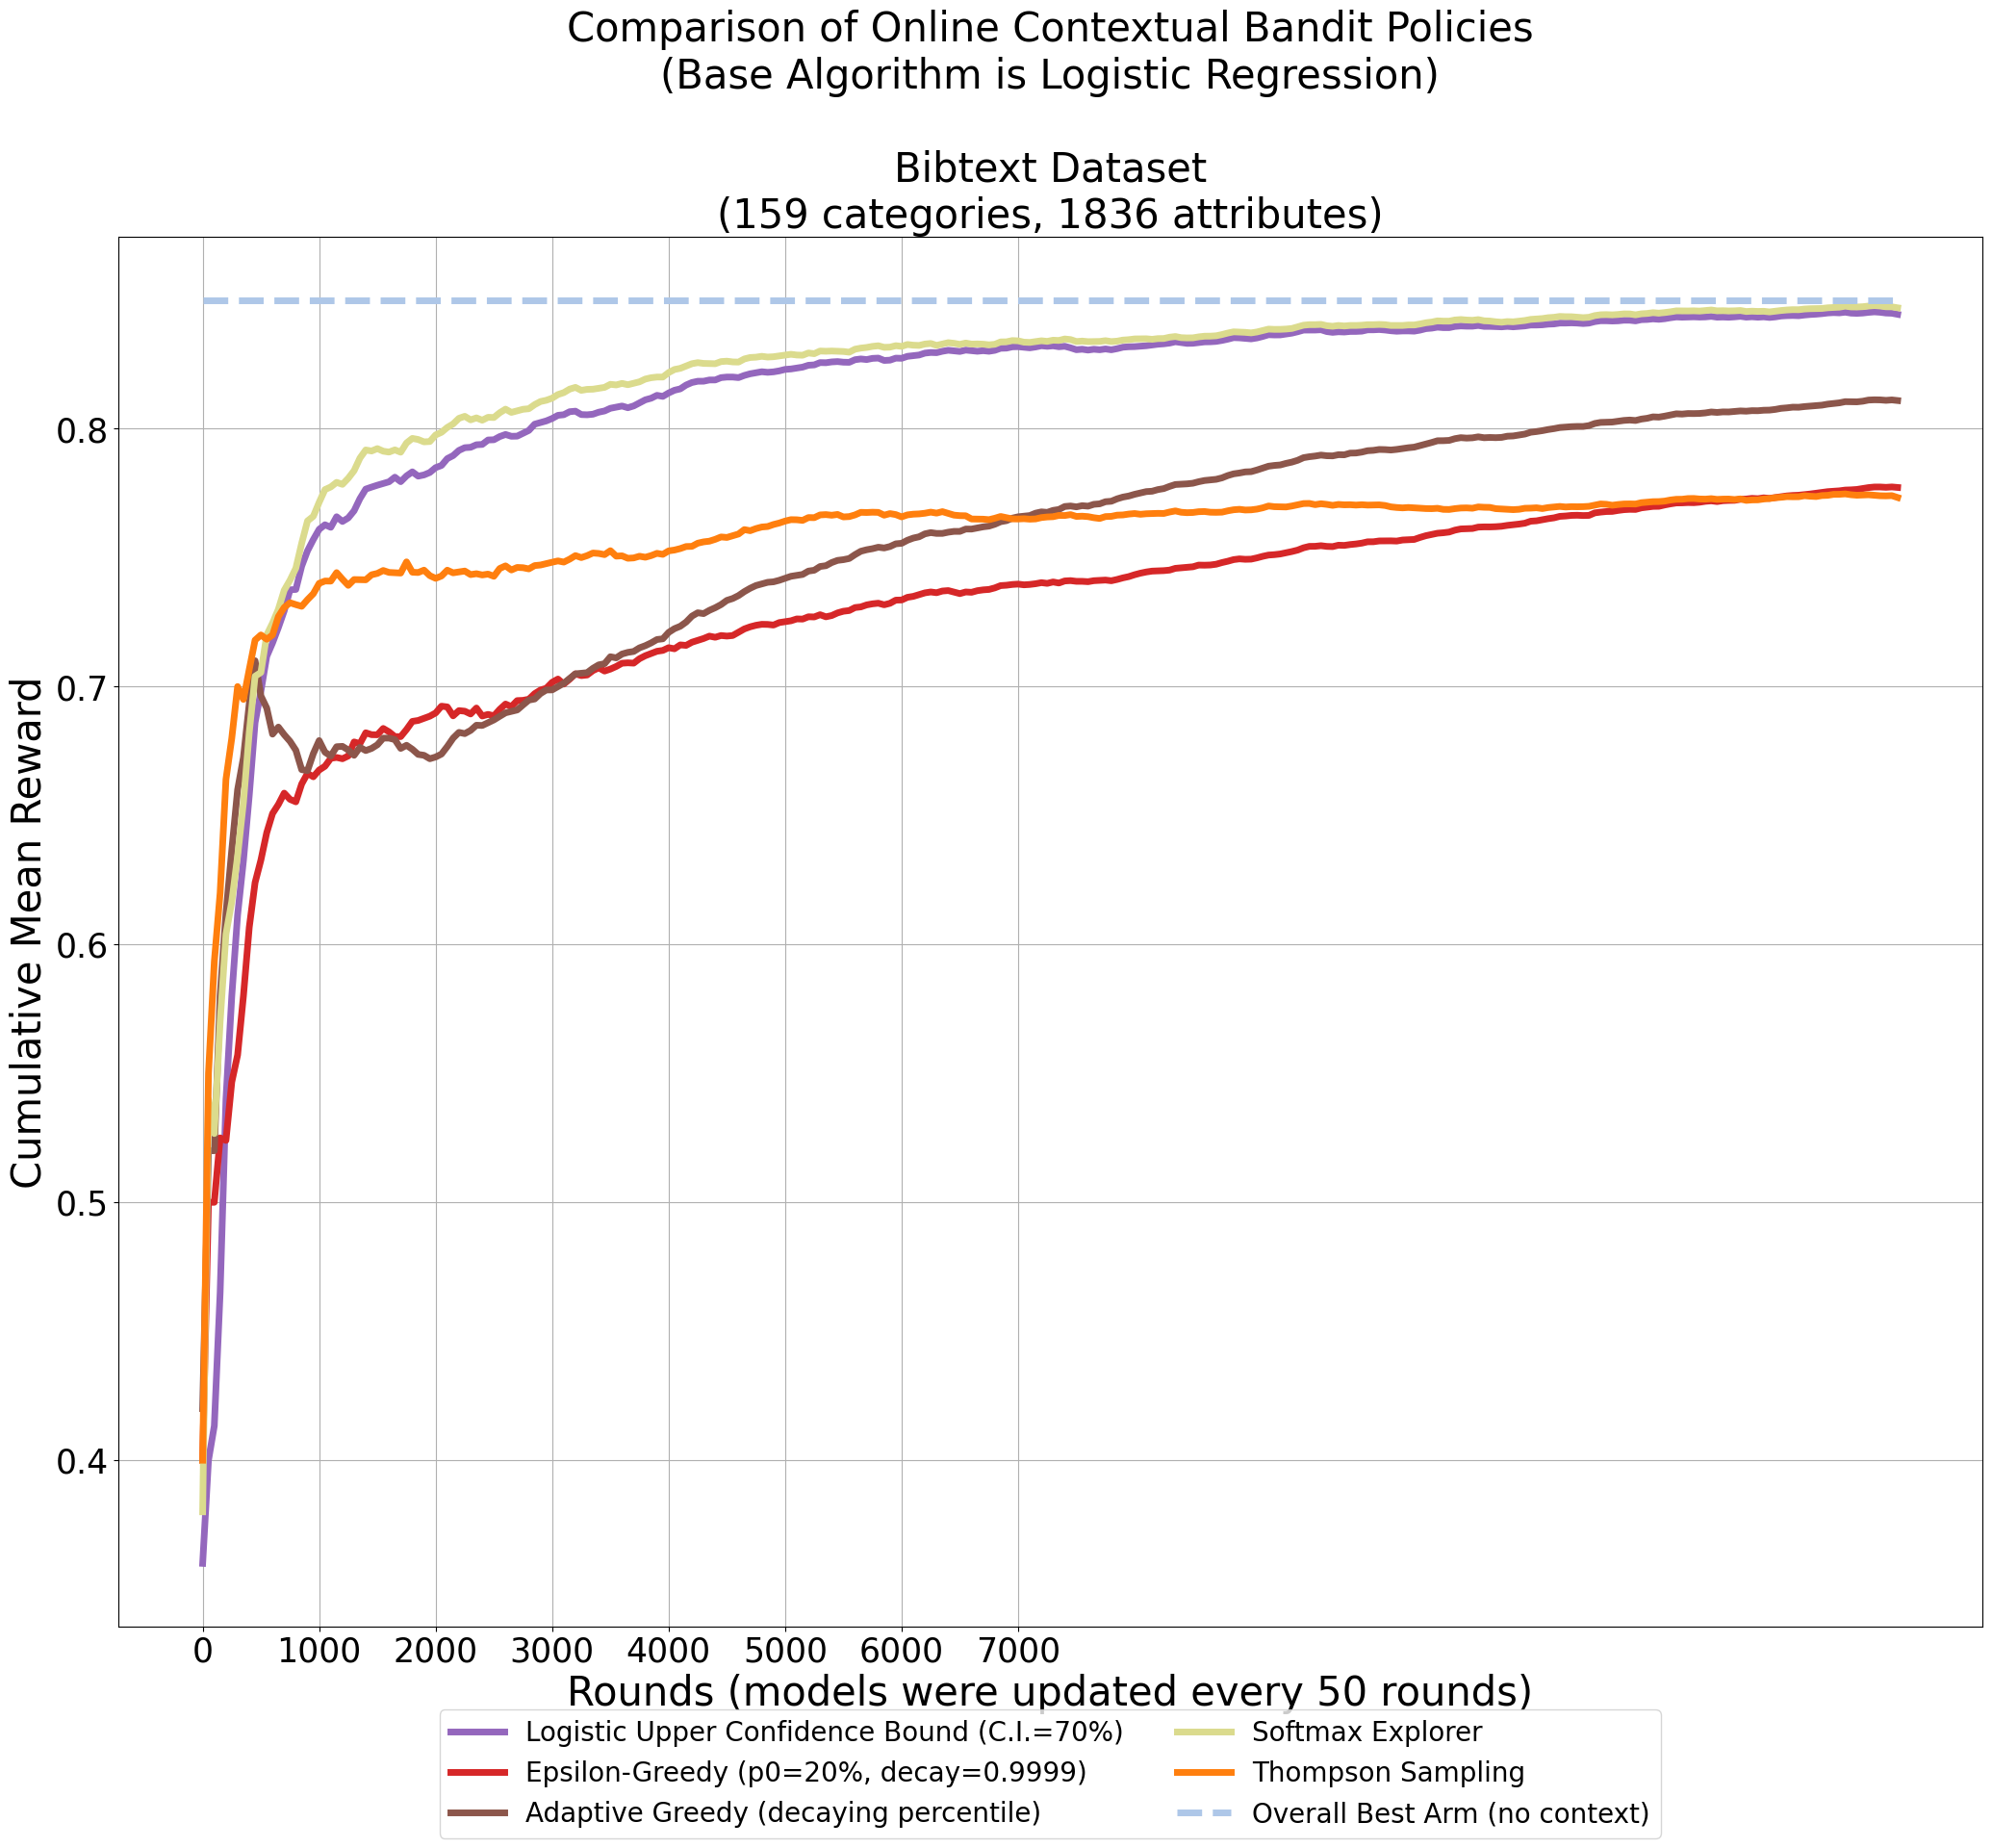

In [45]:
def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew = list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1) * batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors = plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_lucb), label="Logistic Upper Confidence Bound (C.I.=70%)", linewidth=lwd, color=colors[8])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)", linewidth=lwd, color=colors[6])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying percentile)", linewidth=lwd, color=colors[10])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd, color=colors[17])
plt.plot(get_mean_reward(rewards_bts), label="Thompson Sampling", linewidth=lwd, color=colors[2])
plt.plot(np.repeat(y.mean(axis=0).max(), len(rewards_sft)), label="Overall Best Arm (no context)", linewidth=lwd, color=colors[1], ls='dashed')

# Adjust legend positioning and appearance
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=2, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])

plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)', size=30)
plt.grid()
plt.show()

### Softmax explorer is giving the best cumulative mean reward

In [26]:
best_model=models[3]

In [53]:
y_actions=best_model.predict(test_df)

In [61]:
y_actions

array([ 9,  9,  9, ...,  9, 10,  9])

In [64]:
with open('sft_model.pkl', 'wb') as f:
    cloudpickle.dump(models[3], f)